# 使用 Keras 搭建人工神经网络

### 一、查看 tensorflow 是否安装成功

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

D:\APYPLA~1\venv_dir\venv1\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\APYPLA~1\venv_dir\venv1\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\APYPLA~1\venv_dir\venv1\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\APYPLA~1\venv_dir\venv1\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

In [2]:
tf.__version__

'1.13.1'

In [3]:
keras.__version__

'2.2.4-tf'

### 二、使用 Keras 加载数据集

Keras 提供一些实用的函数用来获取和加载常见的数据集，包括 MNIST、Fashion MNIST 和第 2 章用过的加州房产数据集。加载 Fashion MNIST：

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

当使用 Keras 加载 MNIST 或 Fashion MNIST 时，和 Scikit-Learn 加载数据的一个重要区别是，每张图片是28 × 28的数组，而不是大小是 784 的 1D 数组。另外像素的强度是用整数（0 到 255）表示的，而不是浮点数（0.0 到 255.0）。看下训练集的形状和类型：

In [5]:
X_train_full.shape

(60000, 28, 28)

In [6]:
X_train_full.dtype

dtype('uint8')

该数据集已经分成了训练集和测试集，但没有验证集。所以要建一个验证集，另外，因为要用梯度下降训练神经网络，必须要对输入特征进行缩放。简单起见，通过除以 255.0 将强度范围变为 0-1：

In [7]:
X_valid,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_valid,y_train = y_train_full[:5000],y_train_full[5000:]

对于 MNIST，当标签等于 5 时，表明图片是手写的数字 5。但对于 Fashion MNIST，需要分类名的列表：

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] 

例如，训练集的第一张图片表示外套：

In [9]:
class_names[y_train[0]]

'Coat'

### 三、用顺序 API 创建模型

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


逐行看下代码：

* 第一行代码创建了一个顺序 模型，这是 Keras 最简单的模型，是由单层神经元顺序连起来的，被称为顺序 API；


* 接下来创建了第一层，这是一个 `Flatten层` ，它的作用是将每个输入图片转变为 1D 数组：如果输入数据是 `X`，该层则计算 `X.reshape(-1, 1)`。该层没有任何参数，只是做一些简单预处理。因为是模型的第一层，必须要指明 `input_shape`，`input_shape` 不包括批次大小，只是实例的形状。另外，第一层也可以是 `keras.layers.InputLayer`，设置 `input_shape=[28,28]`;


* 然后，添加了一个有 300 个神经元的紧密层，激活函数是 ReLU。每个紧密层只负责自身的权重矩阵，权重矩阵是神经元与输入的所有连接权重。紧密层还要负责偏置项（每个神经元都有一个偏置项）向量。当紧密层收到输入数据时，就利用如下公式进行计算：

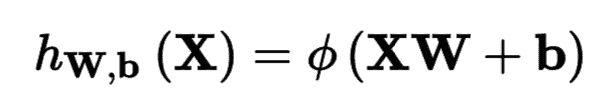

* 接着再添加第二个紧密层，激活函数仍然是 ReLU；


* 最后，加上一个拥有 10 个神经元的输出层（每有一个类就要有一个神经元），激活函数是 softmax（保证输出的概率和等于 1，因为就只有这是个类，具有排他性）。

模型的 `summary()` 方法可以展示所有层，包括每个层的名字（名字是自动生成的，除非建层时指定名字），输出的形状（ `None` 代表批次大小可以是任意值），和参数的数量。最后会输出所有参数的数量，包括可训练和不可训练参数。

这章只有可训练参数（第 11 章可以看到不可训练参数的例子）：

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


紧密层通常有许多参数。比如，第一个隐含层有 `784 × 300` 个连接权重，再加上 `300` 个偏置项，总共有 `235500` 个参数。这么多参数可以让模型具有足够的灵活度以拟合训练数据，但也意味着可能有过拟合的风险，特别是当训练数据不足时。后面再讨论这个问题。

使用属性，获取神经层很容易，可以通过索引或名称获取对应的层：

In [12]:
model.layers

In [13]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [14]:
model.get_layer('dense') is hidden1

True

可以用 `get_weights()` 和 `set_weights()` 方法，获取神经层的所有参数。对于紧密层，参数包括 `连接权重` 和 `偏置项`：

In [15]:
weights,biases = hidden1.get_weights()
weights

array([[-0.07019254, -0.02593466,  0.04743237, ..., -0.05560141,
        -0.00539859,  0.03870178],
       [-0.01807035,  0.02305226, -0.02676559, ..., -0.03859125,
         0.05268484,  0.05615769],
       [-0.052945  ,  0.02088895, -0.04444405, ..., -0.01688186,
         0.06685808, -0.06063293],
       ...,
       [ 0.00094752, -0.02497667, -0.07143408, ..., -0.0537893 ,
        -0.05283489, -0.07083493],
       [-0.04615991,  0.02909764, -0.02926473, ...,  0.05295894,
        -0.00425192, -0.0437604 ],
       [ 0.01494247, -0.00875542,  0.00196617, ..., -0.02588453,
         0.05788939, -0.0147734 ]], dtype=float32)

In [16]:
weights.shape  # 参数 w

(784, 300)

In [17]:
biases.shape  # 偏置项 b

(300,)

紧密层是随机初始化连接权重的（为了避免对称性），偏置项则是 0。如果想使用不同的初始化方法，可以在创建层时设置 `kernel_initializer`（核是连接矩阵的另一个名字）或 `bias_initializer` 。第 11 章会进一步讨论初始化器，初始化器的完整列表见 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Finitializers%2F)。

#### 笔记：

权重矩阵的形状取决于输入的数量。这就是为什么要在创建 `Sequential模型` 的第一层时指定 `input_shape` 。但是，如果不指定形状也没关系：Keras 会在真正搭建模型前一直等待，直到弄清输入的形状（输入真实数据时，或调用 `build()` 方法时）。在搭建模型之前，神经层是没有权重的，也干不了什么事（比如打印模型概要或保存模型）。`所以如果在创建模型时知道输入的形状，最好就设置好。`

### 四、编译模型

创建好模型之后，必须调用 `compile()` 方法，设置损失函数和优化器。另外，还可以指定训练和评估过程中要计算的额外指标的列表：

In [18]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

#### 笔记：

使用 `loss="sparse_categorical_crossentropy"` 等同于 `loss=keras.losses.sparse_categorical_crossentropy` 。

相似的，`optimizer="sgd"` 等同于 `optimizer=keras.optimizers.SGD()` ，`metrics=["accuracy"]` 等同于 `metrics=[keras.metrics.sparse_categorical_accuracy]`。

后面还会使用其他的 `损失函数` 、`优化器` 和 `指标`，它们的完整列表见 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Flosses)、 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Foptimizers)、和[这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Fmetrics。)

解释下这段代码。首先，因为使用的是稀疏标签（每个实例只有一个目标类的索引，在这个例子中，目标类索引是 0 到 9），且就是这十个类，没有其它的，所以使用的是 `"sparse_categorical_crossentropy"` 损失函数。如果每个实例的每个类都有一个目标概率（比如独热向量，`[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]` ，来表示类 3），则就要使用 `"categorical_crossentropy"` 损失函数。如果是做二元分类（有一个或多个二元标签），输出层就得使用 `"sigmoid"` 激活函数，损失函数则变为 `"binary_crossentropy"`。

### 五、训练和评估模型

可以训练模型了。只需调用 fit() 方法：

In [19]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 4s 78us/sample - loss: 0.7187 - acc: 0.7629 - val_loss: 0.4960 - val_acc: 0.8358
Epoch 2/30
55000/55000 [==============================] - 5s 100us/sample - loss: 0.4857 - acc: 0.8311 - val_loss: 0.4482 - val_acc: 0.8476
Epoch 3/30
55000/55000 [==============================] - 7s 125us/sample - loss: 0.4419 - acc: 0.8454 - val_loss: 0.4480 - val_acc: 0.8452
Epoch 4/30
55000/55000 [==============================] - 190s 3ms/sample - loss: 0.4148 - acc: 0.8538 - val_loss: 0.4421 - val_acc: 0.8390
Epoch 5/30
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3949 - acc: 0.8603 - val_loss: 0.4058 - val_acc: 0.8576
Epoch 6/30
55000/55000 [==============================] - 4s 76us/sample - loss: 0.3781 - acc: 0.8673 - val_loss: 0.3667 - val_acc: 0.8718
Epoch 7/30
55000/55000 [==============================] - 4s 67us/sample - loss: 0.3652 - acc: 0.8709 - val_loss: 

这里，向 `fit()` 方法传递了输入特征 `(X_train)` 和目标类 `(y_train)`，还要要训练的周期数（不设置的话，默认的周期数是 1，肯定是不能收敛到一个好的解的）。另外还传递了验证集（它是可选的）。Keras 会在每个周期结束后，测量损失和指标，这样就可以监测模型的表现。如果模型在训练集上的表现优于在验证集上的表现，可能模型在训练集上就过拟合了（或者就是存在 bug，比如训练集和验证集的数据不匹配）。

#### 提示：

除了通过参数 `validation_data` 传递验证集，也可以通过参数 `validation_split` 从训练集分割出一部分作为验证集。比如，`validation_split=0.1` 可以让 `Keras` 使用训练数据（打散前）的末尾 10% 作为验证集。

如果训练集非常倾斜，一些类过渡表达，一些欠表达，在调用 `fit()` 时最好设置 `class_weight` 参数，可以加大欠表达类的权重，减小过渡表达类的权重。Keras 在计算损失时，会使用这些权重。如果每个实例都要加权重，可以设置 `sample_weight`（这个参数优先于 `class_weight` ）。如果一些实例的标签是通过专家添加的，其它实例是通过众包平台添加的，最好加大前者的权重，此时给每个实例都加权重就很有必要。通过在 `validation_data` 元组中，给验证集加上样本权重作为第三项，还可以给验证集添加样本权重。

`fit()` 方法会返回 `History` 对象，包含：`训练参数（history.params）` 、 `周期列表（history.epoch）`、以及最重要的包含训练集和验证集的每个周期后的损失和指标的字典 `（history.history）`。如果用这个字典创建一个 `pandas` 的 `DataFrame` ，然后使用方法 `plot()` ，就可以画出学习曲线，见图 ：

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# history.history #包含训练集和验证集的每个周期后的损失和指标的字典 

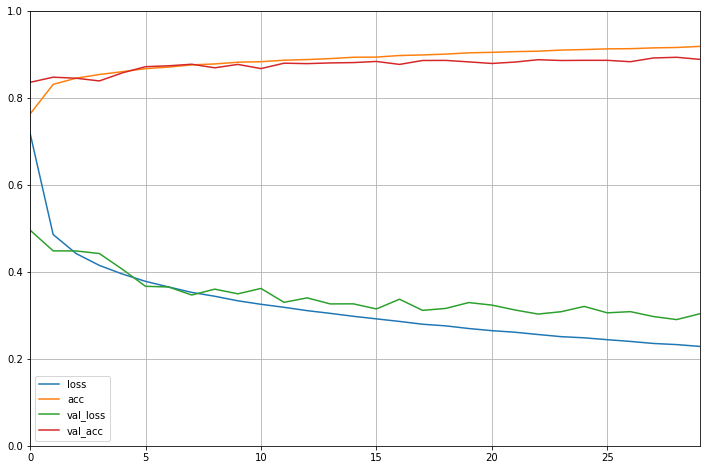

In [22]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True) # 是否加上网格
plt.gca().set_ylim(0,1)
plt.show()

记录了每个周期的平均训练损失和准确率，验证损失和准确率

可以看到，训练准确率和验证准确率稳步提高，训练损失和验证损失持续下降。另外，验证曲线和训练曲线靠的很近，意味着没有什么过拟合。在这个例子中，在训练一开始时，模型在验证集上的表现由于训练集。

`但实际情况是，验证误差是在每个周期结束后算出来的，而训练误差在每个周期期间，用流动平均误差算出来的。所以训练曲线（译者注，图中橙色的那条）实际应该向左移动半个周期。移动之后，就可以发现在训练开始时，训练和验证曲线几乎是完美重合起来的。`

#### 提示：

在绘制训练曲线时，应该向左移动半个周期。

通常只要训练时间足够长，训练集的表现就能超越验证集。从图中可以看到，验证损失仍然在下降，模型收敛的还不好，所以训练应该持续下去。只需要再次调用方法 `fit()` 即可，因为 Keras 可以从断点处继续（验证准确率可以达到 89%。）

如果仍然对模型的表现不满意，就需要调节超参数了。首先是学习率。如果调节学习率没有帮助，就尝试换一个优化器（记得再调节任何超参数之后都重新调节学习率）。如果效果仍然不好，就调节模型自身的超参数，比如层数、每层的神经元数，每个隐藏层的激活函数。还可以调节其它超参数，比如批次大小（通过 `fit()` 的参数 `batch_size` ，默认是 `32`）。本章末尾还会调节超参数。当对验证准确率达到满意之后，就可以用测试集评估 `泛化误差` 。只需使用 `evaluate()` 方法（`evaluate()` 方法包含参数 `batch_size` 和 `sample_weight`）：

一、经验误差（训练误差）与泛化误差

* 经验误差（训练误差）：模型在训练集上的误差称为“经验误差”（empirical error）或者“训练误差”“training error”。


* 泛化误差：模型在新样本集（测试集）上的误差称为“泛化误差”（generalization error）。


In [38]:
x_test = X_test/255.0

In [39]:
model.evaluate(x_test,y_test)

10000/10000 [==============================] - 0s 30us/sample - loss: 0.3404 - acc: 0.8771


[0.3404469667673111, 0.8771]

### 5、使用模型进行预测

接下来，就可以用模型的predict()方法对新实例做预测了。因为并没有新实例，所以就用测试集的前 3 个实例来演示：

In [41]:
y_predict = model.predict(x_test[:3])
y_predict.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.01, 0.  , 0.97],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

可以看到，模型会对每个实例的每个类（从 0 到 9）都给出一个概率。

如果只关心概率最高的类（即使概率不高），可以使用方法 `predict_classes()：`

In [42]:
y_predict_class = model.predict_classes(x_test[:3])
y_predict_class

array([9, 2, 1], dtype=int64)

In [44]:
np.array(class_names)[y_predict_class]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
X_train[1].shape

(28, 28)

In [47]:
from PIL import Image

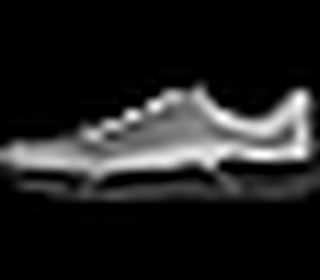

In [66]:
Image.fromarray(X_test[9].astype(np.uint8)).resize((320, 280), Image.ANTIALIAS) # 鞋子
Image.fromarray(X_test[2].astype(np.uint8)).resize((320, 280), Image.ANTIALIAS) # 裤子
Image.fromarray(X_test[1].astype(np.uint8)).resize((320, 280), Image.ANTIALIAS) # 👕

### 6、使用顺序 API 搭建回归 MLP

接下来使用回归神经网络来处理加州房价问题。简便起见，使用 `Scikit-Learn` 的 `fetch_california_housing()` 函数来加载数据。这个数据集比第 2 章所用的数据集简单，因为它只包括数值特征（没有 `ocean_proximity` ），也不包括缺失值。加载好数据之后，将数据集分割成训练集、验证集和测试集，并做特征缩放：

In [67]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [68]:
hoursing = fetch_california_housing()

x_train_full,x_test,y_train_full,y_test = train_test_split(hoursing.data,hoursing.target)
x_train,x_valid,y_train,y_valid = train_test_split(x_train_full,y_train_full) 

In [72]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_valid = ss.transform(x_valid)
x_test = ss.transform(x_test)

In [82]:
x_test[1]

array([ 0.09617197, -0.59865946,  0.53649872, -0.31531635, -0.23290533,
        0.00898411, -0.78337866,  1.08349551])

In [78]:
x_train.shape

(11610, 8)

In [77]:
X_train.shape

(55000, 28, 28)

In [83]:
model = keras.models.Sequential(
    
    [
        keras.layers.Dense(30,activation='relu',input_shape=x_train.shape[1:]),
        keras.layers.Dense(1)
    ]
    )

model.compile(loss='mean_squared_error',optimizer='sgd')
history = model.fit(x_train,y_train,epochs=20,validation_data=(x_valid,y_valid))
mse_err = model.evaluate(x_test,y_test)
x_new = x_test[:3]
y_pre = model.predict(x_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 53us/sample - loss: 0.8606 - val_loss: 0.4976
Epoch 2/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5305 - val_loss: 0.4416
Epoch 3/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5233 - val_loss: 0.4071
Epoch 4/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4761 - val_loss: 0.4310
Epoch 5/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4556 - val_loss: 0.4887
Epoch 6/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5444 - val_loss: 0.4579
Epoch 7/20
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4719 - val_loss: 0.4771
Epoch 8/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.4401 - val_loss: 0.5394
Epoch 9/20
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4287 - val_l

In [84]:
mse_err

0.50315572644851

In [86]:
y_test[:3]

array([3.097, 1.368, 2.906])

In [85]:
y_pre

array([[3.3128605],
       [1.5488467],
       [3.4599814]], dtype=float32)

可以看到，使用顺序 API 是很方便的。但是，尽管Sequential十分常见，但用它搭建复杂拓扑形态或多输入多输出的神经网络还是不多。所以，Keras 还提供了函数式 API。

### 8、使用函数式 API 搭建复杂模型

我们来搭建一个这样的神经网络，来解决加州房价问题：
<div align=center><img  src="./static/使用函数式 API 搭建复杂模型1.jpg"/></div>


In [93]:
input_ = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation='relu')(input_)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_,hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_],outputs=[output])

每行代码的作用：

* 首先创建一个Input对象。包括模型输入的形状shape和数据类型dtype。模型可能会有多种输入。


* 然后，创建一个有 30 个神经元的紧密层，激活函数是 ReLU。创建好之后，将其作为函数，直接将输入传给它。这就是函数式 API 的得名原因。这里只是告诉 Keras 如何将层连起来，并没有导入实际数据。


* 然后创建第二个隐藏层，还是将其作为函数使用，输入时第一个隐藏层的输出；


* 接着，创建一个连接Concatenate层，也是作为函数使用，将输入和第二个隐藏层的输出连起来。可以使用keras.layers.concatenate()。


* 然后创建输出层，只有一个神经元，没有激活函数，将连接层的输出作为输入。


* 最后，创建一个 Keras 的Model，指明输入和输出。

搭建好模型之后，重复之前的步骤：编译模型、训练、评估、做预测。

但是如果你想将部分特征发送给 wide 路径，将部分特征（可以有重叠）发送给 deep 路径，该怎么做呢？答案是可以使用多输入。例如，`假设向 wide 路径发送 5 个特征（特征 0 到 4）`，`向 deep 路径发送 6 个特征（特征 2 到 7）`：

<div align=center><img  src="./static/使用函数式 API 搭建复杂模型2.jpg"/></div>


In [99]:
input_A = keras.layers.Input(shape=[5],name='wide_input')
input_B = keras.layers.Input(shape=[6],name='deep_input')
hidden1 = keras.layers.Dense(30,activation='relu')(input_B)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A,hidden2])
output = keras.layers.Dense(1,name='output')(concat)
model = keras.Model(inputs = [input_A,input_B],outputs=[output])

代码非常浅显易懂。值得注意的是，在创建模型时，我们指明了 `inputs=[input_A, input_B]` 。然后就可以像通常那样编译模型了，但当调用 `fit()` 时，不是传入矩阵 `X_train` ，而是传入一对矩阵 `(X_train_A, X_train_B)` ：每个输入一个矩阵。同理调用 `evaluate()` 或 `predict()` 时，`X_valid、X_test、X_new` 也要变化：

In [100]:
model.compile(loss='mse',optimizer=keras.optimizers.SGD(lr=1e-3))
x_train_A,x_train_B = x_train[:,:5],x_train[:,2:]
x_valid_A,x_valid_B = x_valid[:,:5],x_valid[:,2:]
x_test_A,x_test_B = x_test[:,:5],x_test[:,2:]
x_new_A,x_new_B = x_test_A[:3],x_test_B[:3]
history = model.fit((x_train_A,x_train_B),y_train,epochs=20,validation_data=((x_valid_A,x_valid_B),y_valid))
mse_err = model.evaluate((x_test_A,x_test_B),y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 67us/sample - loss: 2.2289 - val_loss: 0.9622
Epoch 2/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.7626 - val_loss: 0.6544
Epoch 3/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6209 - val_loss: 0.5652
Epoch 4/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5739 - val_loss: 0.5266
Epoch 5/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5497 - val_loss: 0.5031
Epoch 6/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5341 - val_loss: 0.4890
Epoch 7/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5226 - val_loss: 0.4773
Epoch 8/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5144 - val_loss: 0.4683
Epoch 9/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5077 - val_l

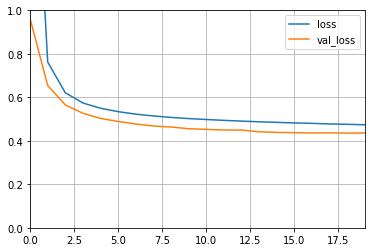

In [106]:
pd.DataFrame(history.history).plot()
plt.grid(True) # 是否加上网格
plt.gca().set_ylim(0,1)
plt.show()

In [101]:
y_pred = model.predict((x_new_A,x_new_B))

In [103]:
y_pred

array([[3.1915767],
       [1.4668725],
       [2.8040106]], dtype=float32)

In [104]:
y_test[:3]

array([3.097, 1.368, 2.906])

有以下要使用多输入的场景：

任务要求。例如，你想定位和分类图片中的主要物体。这既是一个回归任务（找到目标中心的坐标、宽度和高度）和分类任务。

相似的，对于相同的数据，你可能有多个独立的任务。当然可以每个任务训练一个神经网络，`但在多数情况下，同时对所有任务训练一个神经网络，每个任务一个输出，后者的效果更好。`这是因为神经网络可以在不同任务间学习有用的数据特征。例如，在人脸的多任务分类时，你可以用一个输出做人物表情的分类（微笑惊讶等等），用另一个输出判断是否戴着眼镜。

另一种情况是作为一种正则的方法（即，一种降低过拟合和提高泛化能力的训练约束）。`例如，你想在神经网络中加入一些辅助输出（见图 10-16），好让神经网络的一部分依靠自身就能学到一些东西。`

<div align=center><img  src="./static/使用函数式 API 搭建复杂模型3.jpg"/></div>


添加额外的输出很容易：只需要将输出和相关的层连起来、将输出写入输出列表就行。例如，下面的代码搭建的就是上图的架构：

In [131]:
input_A = keras.layers.Input(shape=[5],name='wide_input')
input_B = keras.layers.Input(shape=[6],name='deep_input')
hidden1 = keras.layers.Dense(30,activation='relu')(input_B)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_A,hidden2])
output = keras.layers.Dense(1,name = 'main_output')(concat)
aux_output = keras.layers.Dense(1,name = 'aux_output')(hidden2)
model = keras.Model(inputs = [input_A,input_B],outputs = [output,aux_output])

每个输出都要有自己的损失函数。因此在编译模型时，需要传入损失列表（如果只传入一个损失，Keras 会认为所有输出是同一个损失函数）。Keras 默认计算所有损失，将其求和得到最终损失用于训练。主输出比辅助输出更值得关心，所以要提高它的权重，如下所示：

In [132]:
model.compile(loss=['mse','mse'],loss_weights=[0.9,0.1],optimizer='sgd')

此时若要训练模型，必须给每个输出贴上标签。在这个例子中，主输出和辅输出预测的是同一件事，因此标签相同。传入数据必须是 `(y_train, y_train)（y_valid和y_test也是如此）`：

In [133]:
history = model.fit((x_train_A,x_train_B),(y_train,y_train),epochs=20,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 72us/sample - loss: 1.3387 - main_output_loss: 1.1831 - aux_output_loss: 2.7363 - val_loss: 0.5789 - val_main_output_loss: 0.4894 - val_aux_output_loss: 1.3822
Epoch 2/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.6107 - main_output_loss: 0.5335 - aux_output_loss: 1.3042 - val_loss: 0.5515 - val_main_output_loss: 0.4830 - val_aux_output_loss: 1.1669
Epoch 3/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5468 - main_output_loss: 0.4772 - aux_output_loss: 1.1726 - val_loss: 0.6126 - val_main_output_loss: 0.5648 - val_aux_output_loss: 1.0416
Epoch 4/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5477 - main_output_loss: 0.4888 - aux_output_loss: 1.0787 - val_loss: 0.5927 - val_main_output_loss: 0.5499 - val_aux_output_loss: 0.9771
Epoch 5/20
11610/11610 [==============================] - 0s 37us/s

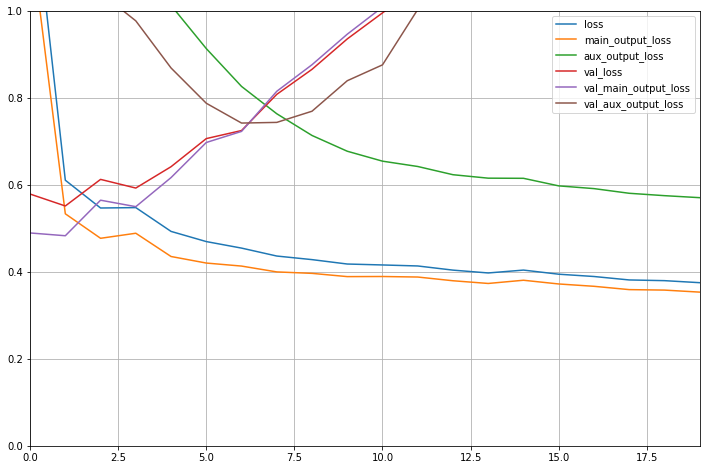

In [134]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.ylim(0,1)
plt.show()

当评估模型时，Keras 会返回总损失和各个损失值：

In [117]:
total_loss,main_loss,aux_loss = model.evaluate((x_test_A,x_test_B),(y_test,y_test))

5160/5160 [==============================] - 0s 24us/sample - loss: 0.7378 - main_output_loss: 0.7496 - aux_output_loss: 0.6188


相似的，方法 `predict()` 会返回每个输出的预测值：

In [119]:
y_pred_main,y_pred_aux = model.predict([x_new_A,x_new_B])

In [120]:
y_pred_main

array([[3.2726226],
       [1.4353402],
       [3.3699298]], dtype=float32)

In [121]:
y_pred_aux

array([[3.1941488],
       [2.2312007],
       [4.128905 ]], dtype=float32)

可以看到，用函数式 API 可以轻易搭建任意架构。接下来再看最后一种搭建 Keras 模型的方法。

### 9、使用子类化 API 搭建动态模型

顺序 API 和函数式 API 都是声明式的：只有声明创建每个层以及层的连接方式，才能给模型加载数据以进行训练和推断。这种方式有其优点：模型可以方便的进行保存、克隆和分享；模型架构得以展示，便于分析；框架可以推断数据形状和类型，便于及时发现错误（加载数据之前就能发现错误）。调试也很容易，因为模型是层的静态图。但是缺点也很明显：模型是静态的。一些模型包含循环、可变数据形状、条件分支，和其它的动态特点。对于这些情况，或者你只是喜欢命令式编程，不妨使用子类化 API。

对 `Model` 类划分子类，在构造器中创建需要的层，调用 `call()` 进行计算。例如，创建一个下面的 `WideAndDeepModel` 类的实例，就可以创建与前面函数式 `API` 例子的同样模型，同样可以进行编译、评估、预测：

In [123]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g., name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

# model = WideAndDeepModel() 

这个例子和函数式 API 很像，除了不用创建输入；只需要在 `call()` 使用参数 `input` ，另外的不同是将层的创建和和使用分割了。最大的差别是，在`call()` 方法中，你可以做任意想做的事：for循环、if语句、低级的 TensorFlow 操作，可以尽情发挥想象（见第 12 章）！子类化 API 可以让研究者试验各种新创意。

然而代价也是有的：模型架构隐藏在 `call()` 方法中，所以 Keras 不能对其检查；`不能保存或克隆`；当调用 `summary()` 时，得到的只是层的列表，没有层的连接信息。另外，Keras 不能提前检查数据类型和形状，所以很容易犯错。所以除非真的需要灵活性，还是使用顺序 API 或函数式 API 吧。

#### 提示：

可以像常规层一样使用 Keras 模型，组合模型搭建任意复杂的架构。

In [125]:
# model.call([keras.layers.Input(shape=[5],name='wide_input'),keras.layers.Input(shape=[6],name='deep_input')])

(<tf.Tensor 'dense_25/BiasAdd:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'dense_26/BiasAdd:0' shape=(?, 1) dtype=float32>)

In [126]:
# model.compile(loss=['mse','mse'],loss_weights=[0.9,0.1],optimizer='sgd')

In [127]:
# history = model.fit((x_train_A,x_train_B),(y_train,y_train),epochs=20,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 68us/sample - loss: 0.9773 - output_1_loss: 0.8841 - output_2_loss: 1.8156 - val_loss: 0.5773 - val_output_1_loss: 0.5300 - val_output_2_loss: 1.0033
Epoch 2/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6584 - output_1_loss: 0.6189 - output_2_loss: 1.0147 - val_loss: 0.4689 - val_output_1_loss: 0.4251 - val_output_2_loss: 0.8641
Epoch 3/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5540 - output_1_loss: 0.5186 - output_2_loss: 0.8782 - val_loss: 0.4923 - val_output_1_loss: 0.4569 - val_output_2_loss: 0.8121
Epoch 4/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5346 - output_1_loss: 0.5044 - output_2_loss: 0.8057 - val_loss: 0.4945 - val_output_1_loss: 0.4596 - val_output_2_loss: 0.8083
Epoch 5/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5056 - output_1_loss: 0.

In [135]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         (None, 6)            0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         (None, 5)            0                                            
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 30)           930         dense_27[0][0]                   
__________________________________________________________________________________________________
concatenat

### 10、保存和恢复模型

使用顺序 API 或函数式 API 时，保存训练好的 Keras 模型和训练一样简单：

In [136]:
# model = keras.layers.Sequential([...]) # or keras.Model([...])
# model.compile([...])
# model.fit([...])
model.save("my_keras_model.h5") 

Keras 使用 HDF5 格式保存模型架构（包括每层的超参数）和每层的所有参数值（连接权重和偏置项）。还保存了优化器（包括超参数和状态）。

通常用脚本训练和保存模型，一个或更多的脚本（或 web 服务）来加载模型和做预测。加载模型很简单：

In [137]:
model = keras.models.load_model("my_keras_model.h5") 

#### 警告：

这种加载模型的方法只对顺序 API 或函数式 API 有用，不适用于子类化 API。对于后者，可以用 save_weights() 和 load_weights() 保存参数，其它的就得手动保存恢复了。

但如果训练要持续数个小时呢？在大数据集上训练，训练时间长很普遍。此时，不仅要在训练结束时保存模型检查点，在一定时间间隔内也要保存，以免电脑宕机造成损失。但是如何告诉 `fit()` 保存检查点呢？ `使用调回`。

### 11、使用调回

`fit()` 方法接受参数 `callbacks` ，可以让用户指明一个 Keras 列表，让 Keras 在训练开始和结束、每个周期开始和结束、甚至是每个批次的前后调用。例如，`ModelCheckpoint` 可以在每个时间间隔保存检查点，默认是每个周期结束之后：

In [142]:
# [...] # 搭建编译模型
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5")
history = model.fit((x_train_A,x_train_B), (y_train,y_train), epochs=20, callbacks=[checkpoint_cb]) 

Epoch 1/20
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3505 - main_output_loss: 0.3321 - aux_output_loss: 0.5171
Epoch 2/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3486 - main_output_loss: 0.3304 - aux_output_loss: 0.5114
Epoch 3/20
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3464 - main_output_loss: 0.3286 - aux_output_loss: 0.5067
Epoch 4/20
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3458 - main_output_loss: 0.3285 - aux_output_loss: 0.5027
Epoch 5/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3451 - main_output_loss: 0.3279 - aux_output_loss: 0.4994
Epoch 6/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3486 - main_output_loss: 0.3324 - aux_output_loss: 0.4948
Epoch 7/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3439 - main_output_loss: 0.3275 - aux_output_loss: 0.4904
Epoch 8/20
11

另外，如果训练时使用了验证集，可以在创建检查点时设定 `save_best_only=True`，只有当模型在验证集上取得最优值时才保存模型。这么做可以不必担心训练时间过长和训练集过拟合：只需加载训练好的模型，就能保证是在验证集上表现最好的模型。下面的代码演示了早停（见第 4 章）：

In [145]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5',save_best_only=True)
history = model.fit((x_train_A,x_train_B), (y_train,y_train),epochs=20,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)),callbacks=[checkpoint_cb])
model = keras.models.load_model('my_keras_model.h5') # roll back to best model 

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.3290 - main_output_loss: 0.3164 - aux_output_loss: 0.4433 - val_loss: 5.0940 - val_main_output_loss: 4.9894 - val_aux_output_loss: 6.0415
Epoch 2/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.3289 - main_output_loss: 0.3169 - aux_output_loss: 0.4406 - val_loss: 5.1121 - val_main_output_loss: 5.0106 - val_aux_output_loss: 6.0259
Epoch 3/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.3277 - main_output_loss: 0.3155 - aux_output_loss: 0.4371 - val_loss: 5.4076 - val_main_output_loss: 5.3040 - val_aux_output_loss: 6.3404
Epoch 4/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3275 - main_output_loss: 0.3158 - aux_output_loss: 0.4341 - val_loss: 5.3917 - val_main_output_loss: 5.2859 - val_aux_output_loss: 6.3365
Epoch 5/20
11610/11610 [==============================] - 1s 43us/s

另一种实现早停的方法是使用 `EarlyStopping` 调回。当检测到经过几个周期（周期数由参数 `patience` 确定），验证集表现没有提升时，就会中断训练，还能自动滚回到最优模型。可以将保存检查点（避免宕机）和早停（避免浪费时间和资源）结合起来：

In [146]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
history = model.fit((x_train_A,x_train_B), (y_train,y_train),epochs=50,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)),callbacks=[checkpoint_cb,early_stopping_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/50
11610/11610 [==============================] - 1s 87us/sample - loss: 0.3272 - main_output_loss: 0.3148 - aux_output_loss: 0.4391 - val_loss: 5.1508 - val_main_output_loss: 5.0420 - val_aux_output_loss: 6.1368
Epoch 2/50
11610/11610 [==============================] - 0s 43us/sample - loss: 0.3266 - main_output_loss: 0.3144 - aux_output_loss: 0.4372 - val_loss: 5.2163 - val_main_output_loss: 5.1107 - val_aux_output_loss: 6.1717
Epoch 3/50
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3269 - main_output_loss: 0.3149 - aux_output_loss: 0.4344 - val_loss: 5.4069 - val_main_output_loss: 5.3014 - val_aux_output_loss: 6.3439
Epoch 4/50
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3272 - main_output_loss: 0.3157 - aux_output_loss: 0.4324 - val_loss: 5.5796 - val_main_output_loss: 5.4756 - val_aux_output_loss: 6.5014
Epoch 5/50
11610/11610 [==============================] - 0s 39us/s

如果还想有其它操控，还可以编写自定义的调回。下面的例子展示了一个可以展示验证集损失和训练集损失比例的自定义（检测过拟合）调回：

In [148]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"])) 

类似的，还可以实现 `on_train_begin()` 、`on_train_end()`、`on_epoch_begin()`、`on_epoch_end()`、`on_batch_begin()`、和 `on_batch_end()` 。如果需要的话，在评估和预测时也可以使用调回（例如为了调试）。对于评估，可以实现 `on_test_begin()`、`on_test_end()`、`on_test_batch_begin()`或 `on_test_batch_end()`（通过 `evaluate()`调用）；对于预测，可以实现 `on_predict_begin()`、`on_predict_end()`、`on_predict_batch_begin()` 或`on_predict_batch_end()`（通过 `predict()` 调用）。

下面来看一个使用 `tf.keras`的必备工具：`TensorBoard` 。

### 11、使用 TensorBoard 进行可视化

`TensorBoard` 是一个强大的交互可视化工具，使用它可以查看训练过程中的学习曲线、比较每次运行的学习曲线、可视化计算图、分析训练数据、查看模型生成的图片、可视化投射到 3D 的多维数据，等等。`TensorBoard` 是 `TensorFlow` 自带的。

要使用 `TensorBoard`，必须修改程序，将要可视化的数据输出为二进制的日志文件 `event files` 。每份二进制数据称为摘要 `summary` ，`TensorBoard` 服务器会监测日志文件目录，自动加载更新并可视化：这样就能看到实时数据（稍有延迟），比如训练时的学习曲线。通常，将 TensorBoard 服务器指向根日志目录，程序的日志写入到它的子目录，这样一个 TensorBoard 服务就能可视化并比较多次运行的数据，而不会将其搞混。

我们先定义 TensorBoard 的根日志目录，还有一些根据当前日期生成子目录的小函数。你可能还想在目录名中加上其它信息，比如超参数的值，方便知道查询的内容：

In [152]:
os.curdir

'.'

In [151]:
root_logdir

'.\\my_logs'

In [149]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22' 

Keras 提供了一个 `TensorBoard()` 调回：

In [153]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit((x_train_A,x_train_B), (y_train,y_train),epochs=50,validation_data=((x_valid_A,x_valid_B),(y_valid,y_valid)),callbacks=[tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/50
11610/11610 [==============================] - 1s 55us/sample - loss: 0.3266 - main_output_loss: 0.3146 - aux_output_loss: 0.4344 - val_loss: 5.3661 - val_main_output_loss: 5.2589 - val_aux_output_loss: 6.3428
Epoch 2/50
11610/11610 [==============================] - 0s 41us/sample - loss: 0.3277 - main_output_loss: 0.3159 - aux_output_loss: 0.4330 - val_loss: 5.3408 - val_main_output_loss: 5.2251 - val_aux_output_loss: 6.4028
Epoch 3/50
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3336 - main_output_loss: 0.3229 - aux_output_loss: 0.4299 - val_loss: 5.4045 - val_main_output_loss: 5.2691 - val_aux_output_loss: 6.6299
Epoch 4/50
11610/11610 [==============================] - 1s 53us/sample - loss: 0.3230 - main_output_loss: 0.3115 - aux_output_loss: 0.4265 - val_loss: 5.7259 - val_main_output_loss: 5.6041 - val_aux_output_loss: 6.8375
Epoch 5/50
11610/11610 [==============================] - 1s 53us/s

Epoch 38/50
11610/11610 [==============================] - 1s 48us/sample - loss: 0.3092 - main_output_loss: 0.3012 - aux_output_loss: 0.3814 - val_loss: 7.1785 - val_main_output_loss: 6.8639 - val_aux_output_loss: 9.9878
Epoch 39/50
11610/11610 [==============================] - 1s 46us/sample - loss: 0.3100 - main_output_loss: 0.3019 - aux_output_loss: 0.3815 - val_loss: 6.9634 - val_main_output_loss: 6.6372 - val_aux_output_loss: 9.9292
Epoch 40/50
11610/11610 [==============================] - 0s 42us/sample - loss: 0.3097 - main_output_loss: 0.3018 - aux_output_loss: 0.3801 - val_loss: 7.4276 - val_main_output_loss: 7.1100 - val_aux_output_loss: 10.3323
Epoch 41/50
11610/11610 [==============================] - 1s 44us/sample - loss: 0.3091 - main_output_loss: 0.3012 - aux_output_loss: 0.3800 - val_loss: 6.8043 - val_main_output_loss: 6.4610 - val_aux_output_loss: 9.8889
Epoch 42/50
11610/11610 [==============================] - 1s 48us/sample - loss: 0.3063 - main_output_loss: 0.

简直不能再简单了。如果运行这段代码，TensorBoard()调回会负责创建日志目录（包括父级目录），在训练过程中会创建事件文件并写入概要。再次运行程序（可能修改了一些超参数）之后，得到的目录结构可能如下：

    my_logs/
    ├── run_2019_06_07-15_15_22
    │   ├── train
    │   │   ├── events.out.tfevents.1559891732.mycomputer.local.38511.694049.v2
    │   │   ├── events.out.tfevents.1559891732.mycomputer.local.profile-empty
    │   │   └── plugins/profile/2019-06-07_15-15-32
    │   │       └── local.trace
    │   └── validation
    │       └── events.out.tfevents.1559891733.mycomputer.local.38511.696430.v2
    └── run_2019_06_07-15_15_49
        └── [...] 


每次运行都会创建一个目录，每个目录都有一个包含训练日志和验证日志的子目录。两者都包括事件文件，训练日志还包括分析追踪信息：它可以让 TensorBoard 展示所有设备上的模型的各个部分的训练时长，有助于定位性能瓶颈。

然后就可以启动 TensorBoard 服务了。一种方式是通过运行命令行。如果是在虚拟环境中安装的 TensorFlow，需要激活虚拟环境。接着，在根目录（也可以是其它路径，但一定要指向日志目录）运行下面的命令：

    $ tensorboard --logdir=./my_logs --port=6006
    TensorBoard 2.0.0 at http://mycomputer.local:6006/ (Press CTRL+C to quit) 


无论是使用哪种方式，都得使用 TensorBoard 的浏览器界面。点击栏SCALARS可以查看学习曲线（见图 ）。左下角选择想要可视化的路径（比如第一次和第二次运行的训练日志），再点击epoch_loss。可以看到，在两次训练过程中，训练损失都是下降的，但第二次下降的更快。事实上，第二次的学习率是 `0.05`（optimizer=keras.optimizers.SGD(lr=0.05)）而不是 `0.001`。

<div align=center><img  src="./static/tensorboard.jpg"/></div>


In [156]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step) 

AttributeError: module 'tensorflow._api.v1.summary' has no attribute 'create_file_writer'